In [4]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
     
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [5]:
inventory_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/inventory_items_optimized.parquet')
order_items= pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')
products = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet')

In [6]:
inventory_items

,inventory_item_id,product_id,inventory_item_created_at,inventory_item_sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,67971,13844,2022-07-02 07:09:20+00:00,2022-07-24 06:33:20+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,67972,13844,2023-12-20 03:28:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,67973,13844,2023-06-04 02:53:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,72863,13844,2021-10-16 22:58:52+00:00,2021-11-22 02:19:52+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,72864,13844,2021-08-07 16:33:00+00:00,NaT,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
...,...,...,...,...,...,...,...,...,...,...,...,...
490700,311018,25590,2021-12-07 12:47:00+00:00,NaT,10.39200,Underwear,ck one Men's Micro Slim Fit Boxer,Calvin Klein,24.00,Men,F220707C3AFE39D1779E0A34AF72BB7F,3
490701,451084,25590,2023-10-10 11:57:57+00:00,2023-11-27 11:28:57+00:00,10.39200,Underwear,ck one Men's Micro Slim Fit Boxer,Calvin Klein,24.00,Men,F220707C3AFE39D1779E0A34AF72BB7F,3
490702,451085,25590,2020-11-20 05:55:00+00:00,NaT,10.39200,Underwear,ck one Men's Micro Slim Fit Boxer,Calvin Klein,24.00,Men,F220707C3AFE39D1779E0A34AF72BB7F,3
490703,486057,25590,2023-02-26 22:35:12+00:00,2023-04-23 01:24:12+00:00,10.39200,Underwear,ck one Men's Micro Slim Fit Boxer,Calvin Klein,24.00,Men,F220707C3AFE39D1779E0A34AF72BB7F,3


In [7]:
order_items_merge = pd.merge(order_items, inventory_items [['product_id' , 'cost', 'product_category', 'product_name', 'product_brand','product_department']] , on = 'product_id' , how = 'inner')
order_items_merge

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
1,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
2,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
3,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
4,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588762,143759,98984,78981,24447,388091,Shipped,2022-03-13 10:29:49+00:00,2022-03-14 01:27:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588763,143759,98984,78981,24447,388091,Shipped,2022-03-13 10:29:49+00:00,2022-03-14 01:27:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588764,143759,98984,78981,24447,388091,Shipped,2022-03-13 10:29:49+00:00,2022-03-14 01:27:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588765,143759,98984,78981,24447,388091,Shipped,2022-03-13 10:29:49+00:00,2022-03-14 01:27:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men


In [8]:
order_items_unique = order_items_merge.drop_duplicates(subset=['order_item_id'])
order_items_unique

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
16,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
32,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
48,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
64,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588671,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588692,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588713,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men
3588725,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men


In [9]:
order_items_unique = order_items_unique[order_items_unique['created_at']<"2023-12-01"]
order_items_unique

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaT,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
16,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
64,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
80,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
96,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588671,9674,6679,5325,24447,26095,Returned,2020-12-23 00:05:01+00:00,2020-12-25 22:54:00+00:00,2020-12-28 07:08:00+00:00,2020-12-30 22:43:00+00:00,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588692,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588713,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men
3588725,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men


In [10]:
order_items_extracted = order_items_unique[(order_items_unique['status']!="Returned") & (order_items_unique['status'] != "Cancelled")]
order_items_extracted

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department
16,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
64,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
80,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women
96,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Women
107,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52+00:00,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588659,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men
3588692,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men
3588713,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men
3588725,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men


In [11]:
order_items_extracted['profit'] = order_items_extracted['sale_price'] - order_items_extracted['cost']
order_items_extracted

,order_item_id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department,profit
16,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,0.011700
64,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,0.011700
80,154022,106052,84693,14235,415780,Shipped,2023-09-19 09:13:08+00:00,2023-09-16 09:24:00+00:00,NaT,NaT,0.02,0.008300,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,Women,0.011700
96,67253,46269,37023,14159,181497,Complete,2021-10-31 01:26:46+00:00,2021-11-01 17:47:00+00:00,2021-11-02 13:29:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Women,0.312620
107,116116,80002,63821,14159,313368,Complete,2022-04-01 13:25:52+00:00,2022-03-31 05:13:00+00:00,2022-04-02 22:18:00+00:00,NaT,0.49,0.177380,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,Women,0.312620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588659,51581,35450,28392,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men,516.483001
3588692,7801,5416,4283,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999
3588713,62986,43364,34691,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.00,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men,516.483001
3588725,106577,73418,58623,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.00,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999


In [12]:
order_items_extracted_group = order_items_extracted.groupby('user_id').agg({'order_id' : 'nunique' , 'sale_price' : 'sum'})
order_items_extracted_group

,order_id,sale_price
user_id,,
1,1,159.990000
2,1,22.000000
3,4,402.200001
4,1,148.000000
6,1,144.820004
...,...,...
99989,1,15.120000
99992,1,55.950001
99996,2,123.870001


In [13]:
order_items_extracted_group = order_items_extracted_group.rename(columns={'order_id': 'frequency'}) # 컬럼명 변경

order_items_extracted_group['monetary'] = order_items_extracted_group['sale_price'] / order_items_extracted_group['frequency']
order_items_extracted_group

,frequency,sale_price,monetary
user_id,,,
1,1,159.990000,159.990000
2,1,22.000000,22.000000
3,4,402.200001,100.550000
4,1,148.000000,148.000000
6,1,144.820004,144.820004
...,...,...,...
99989,1,15.120000,15.120000
99992,1,55.950001,55.950001
99996,2,123.870001,61.935000


In [14]:
# Recency 계산 (데이터 제일 최근 날짜 + 2일 기준)
recency = order_items_extracted.groupby('user_id')['created_at'].max().reset_index()
recency = recency.assign(recency = (order_items_extracted['created_at'].max()+ pd.to_timedelta(1, unit='d') - recency['created_at']).dt.days)
recency
recency['recency-1'] = recency['recency'].max() - recency['recency']+1

In [15]:
rfm = recency[['user_id', 'recency-1']].merge(order_items_extracted_group, on='user_id')
rfm['monetary'] = rfm['monetary'].astype(int)
rfm['recency-1'] = rfm['recency-1'].astype(int)
rfm

,user_id,recency-1,frequency,sale_price,monetary
0,1,1291,1,159.990000,159
1,2,1141,1,22.000000,22
2,3,1675,4,402.200001,100
3,4,1381,1,148.000000,148
4,6,1191,1,144.820004,144
...,...,...,...,...,...
58459,99989,1699,1,15.120000,15
58460,99992,1311,1,55.950001,55
58461,99996,1529,2,123.870001,61
58462,99998,1658,3,116.990000,38


In [16]:
rfm = rfm.drop(columns=['sale_price'])
rfm

,user_id,recency-1,frequency,monetary
0,1,1291,1,159
1,2,1141,1,22
2,3,1675,4,100
3,4,1381,1,148
4,6,1191,1,144
...,...,...,...,...
58459,99989,1699,1,15
58460,99992,1311,1,55
58461,99996,1529,2,61
58462,99998,1658,3,38


# minmax 스케일링

In [17]:
min_values = rfm.min()
min_values

user_id      1
recency-1    1
frequency    1
monetary     0
dtype: Int64

In [18]:
def custom_minmax_scaling_except_id(rfm, min_value=1, max_value=20):
    # 'user_id' 칼럼 제외
    numerical_rfm = rfm.drop(columns=['user_id'])

    # Min-Max 스케일링 적용
    min_val = numerical_rfm.min()
    max_val = numerical_rfm.max()
    scaled_rfm = (numerical_rfm - min_val) / (max_val - min_val) * (max_value - min_value) + min_value
    return scaled_rfm

# 'user_id' 칼럼을 제외한 숫자 데이터로 Min-Max 스케일링 수행
scaled_rfm = custom_minmax_scaling_except_id(rfm)

In [19]:
scaled_rfm

,recency-1,frequency,monetary
0,14.708054,1.000000,3.252796
1,13.114094,1.000000,1.311708
2,18.788591,20.000000,2.416853
3,15.664430,1.000000,3.096943
4,13.645414,1.000000,3.040268
...,...,...,...
58459,19.043624,1.000000,1.212528
58460,14.920582,1.000000,1.779269
58461,17.237136,7.333333,1.864280
58462,18.607942,13.666667,1.538404


In [20]:
scaled_rfm['user_id'] = rfm['user_id']
scaled_rfm

,recency-1,frequency,monetary,user_id
0,14.708054,1.000000,3.252796,1
1,13.114094,1.000000,1.311708,2
2,18.788591,20.000000,2.416853,3
3,15.664430,1.000000,3.096943,4
4,13.645414,1.000000,3.040268,6
...,...,...,...,...
58459,19.043624,1.000000,1.212528,99989
58460,14.920582,1.000000,1.779269,99992
58461,17.237136,7.333333,1.864280,99996
58462,18.607942,13.666667,1.538404,99998


In [21]:
# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
scaled_rfm = scaled_rfm.assign(G2=scaled_rfm['monetary'])  # 과거 고객 가치 (Monetary를 사용)
# scaled_rfm_data = scaled_rfm[['user_id', 'monetary']].copy().rename(columns={'monetary': 'G'})  # 과거 고객 가치 (Monetary를 사용)
scaled_rfm = scaled_rfm.assign(K2=scaled_rfm['monetary'] * scaled_rfm['frequency'])  # 현재 고객 가치
scaled_rfm = scaled_rfm.assign(S2=scaled_rfm['monetary'] * scaled_rfm['frequency'] / scaled_rfm['recency-1'])  # 잔존 고객 가치
scaled_rfm = scaled_rfm.assign(M2=np.log(scaled_rfm['frequency']) * scaled_rfm['monetary'])  # 모멘텀 고객 가치
# scaled_rfm = scaled_rfm.assign(S=scaled_rfm['monetary'] * scaled_rfm['frequency-1'] / scaled_rfm['recency-1-1'])  # 소셜 고객 가치
# scaled_rfm = scaled_rfm.assign(Q2=scaled_rfm['monetary'] / scaled_rfm['frequency'])  # 품질 고객 가치
scaled_rfm = scaled_rfm.assign(J2=scaled_rfm['monetary'] *(1/scaled_rfm['recency-1']))  # 행동 고객 가치
# scaled_rfm = scaled_rfm.assign(J2=scaled_rfm['monetary'] / np.log1p(scaled_rfm['recency-1']))  # 행동 고객 가치!##!! 이게 맞을 것임.

     

In [22]:
scaled_rfm_CLV = scaled_rfm.assign(CLV2 = scaled_rfm[['G2', 'K2', 'S2', 'M2', 'J2']].sum(axis=1))
scaled_rfm_CLV

,recency-1,frequency,monetary,user_id,G2,K2,S2,M2,J2,CLV2
0,14.708054,1.000000,3.252796,1,3.252796,3.252796,0.221158,0.000000,0.221158,6.947908
1,13.114094,1.000000,1.311708,2,1.311708,1.311708,0.100023,0.000000,0.100023,2.823461
2,18.788591,20.000000,2.416853,3,2.416853,48.337062,2.572682,7.240245,0.128634,60.695476
3,15.664430,1.000000,3.096943,4,3.096943,3.096943,0.197705,0.000000,0.197705,6.589296
4,13.645414,1.000000,3.040268,6,3.040268,3.040268,0.222805,0.000000,0.222805,6.526147
...,...,...,...,...,...,...,...,...,...,...
58459,19.043624,1.000000,1.212528,99989,1.212528,1.212528,0.063671,0.000000,0.063671,2.552398
58460,14.920582,1.000000,1.779269,99992,1.779269,1.779269,0.119249,0.000000,0.119249,3.797037
58461,17.237136,7.333333,1.864280,99996,1.864280,13.671390,0.793136,3.714448,0.108155,20.151409
58462,18.607942,13.666667,1.538404,99998,1.538404,21.024857,1.129886,4.022865,0.082675,27.798687


In [23]:
# Selecting relevant columns for clustering
X2 = scaled_rfm_CLV[['G2', 'K2', 'S2', 'M2', 'J2']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans_GKSMQJ2 = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_GKSMQJ2.fit(X2)

# Adding cluster labels to the DataFrame
scaled_rfm_CLV['cluster_CLV2'] = kmeans_GKSMQJ2.labels_ # 이전 해둔것 덮어쓰기로 하게 되어있는데 의도하신건지?

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans_GKSMQJ2.cluster_centers_, columns=['G2', 'K2', 'S2', 'M2', 'J2'])
display(cluster_centers)

# Checking the count of data points in each cluster
print(scaled_rfm_CLV['cluster_CLV2'].value_counts())

,G2,K2,S2,M2,J2
0,2.152918,2.152918,0.165855,8.593126e-14,0.165855
1,2.514378,22.284917,1.387119,5.339674e+00,0.158152
2,2.831632,35.830190,2.127594,6.992872e+00,0.170942
3,1.996399,12.801131,0.817631,3.386475e+00,0.132042
4,4.059246,58.326677,3.444403,1.052711e+01,0.241699


cluster_CLV2
0    41386
3     8788
1     5116
2     2537
4      637
Name: count, dtype: int64


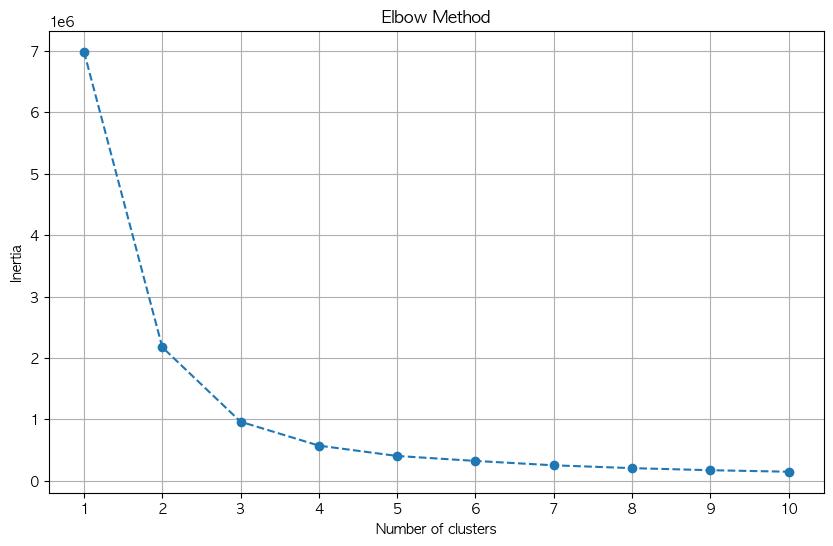

In [24]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Calculate the inertia for different values of k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X2)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

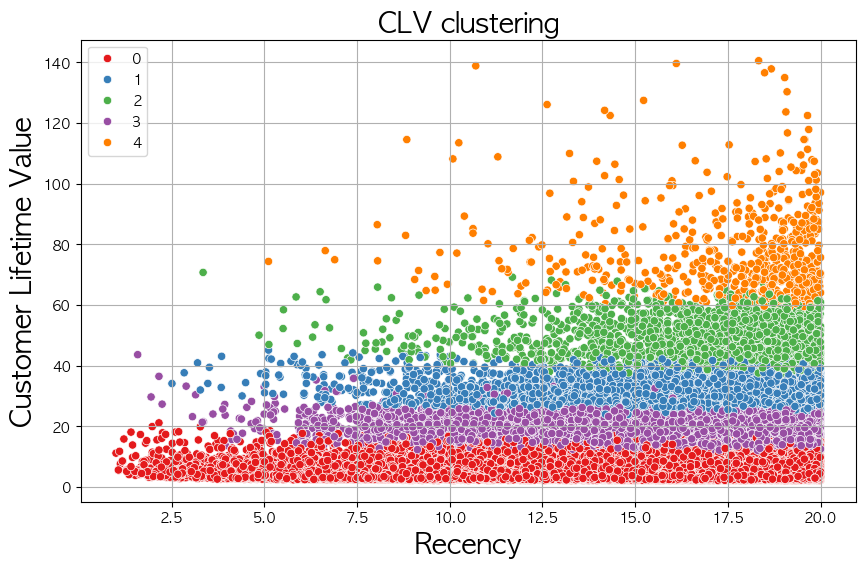

In [25]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency-1', y='CLV2', hue='cluster_CLV2', data=scaled_rfm_CLV, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency', fontsize=20)
plt.ylabel('Customer Lifetime Value', fontsize=20)
plt.title('CLV clustering', fontsize=20)
plt.legend()
plt.grid(True)
plt.show()

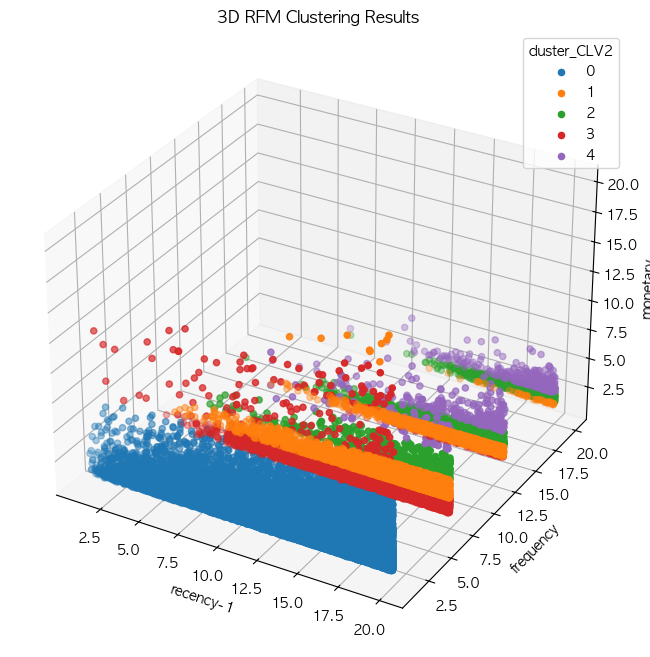

In [26]:
x_feature = 'recency-1'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in scaled_rfm_CLV.groupby('cluster_CLV2'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='cluster_CLV2')

In [27]:
scaled_rfm_CLV_detail = scaled_rfm_CLV.groupby('cluster_CLV2').agg({
    'recency-1': ['mean', 'min', 'max'],
    'frequency': ['mean', 'min', 'max'],
    'monetary': ['mean', 'min', 'max'],
    'CLV2': ['mean', 'min', 'max', 'count']
})
scaled_rfm_CLV_detail

recency-1                  frequency                       \
                   mean       min   max       mean       min        max   
cluster_CLV2                                                              
0             15.097859  1.000000  20.0   1.000000  1.000000   1.000000   
1             16.919468  2.508949  20.0   9.692859  1.000000  20.000000   
2             17.395996  3.348434  20.0  14.071081  7.333333  20.000000   
3             16.610904  1.584452  20.0   7.211538  1.000000  13.666667   
4             17.495523  5.112416  20.0  16.082679  7.333333  20.000000   

              monetary                            CLV2                         \
                  mean       min        max       mean        min         max   
cluster_CLV2                                                                    
0             2.153061  1.000000   8.098434   4.637850   2.101730   21.171944   
1             2.514656  1.212528  20.000000  31.690281  23.632923   45.157372   
2             2.831907  1.467562   6.270694  47.956980  36.953839   70.768287   
3             1.995794  1.042506  17.166294  19.138281  11.353363   43.659874   
4             4.059246  2.374348  10.181208  76.599133  59.500833  140.555006   

                     
              count  
cluster_CLV2         
0             41386  
1              5116  
2              2537  
3              8788  
4               637

In [28]:
scaled_rfm_CLV_detail = scaled_rfm_CLV.groupby('cluster_CLV2').agg({
    'G2': ['mean', 'min', 'max'],
    'K2': ['mean', 'min', 'max'],
    'S2': ['mean', 'min', 'max'],
    'M2': ['mean', 'min', 'max'],
    # 'Q2': ['mean', 'min', 'max'],
    'J2': ['mean', 'min', 'max'],
    'CLV2': ['mean', 'min', 'max', 'count']
})
scaled_rfm_CLV_detail

G2                              K2                         \
                  mean       min        max       mean        min         max   
cluster_CLV2                                                                    
0             2.153061  1.000000   8.098434   2.153061   1.000000    8.098434   
1             2.514656  1.212528  20.000000  22.291001  17.515784   29.157594   
2             2.831907  1.467562   6.270694  35.832820  28.841163   47.203579   
3             1.995794  1.042506  17.166294  12.804302   7.645041   17.733035   
4             4.059246  2.374348  10.181208  58.326677  46.504599  111.812081   

                    S2                              M2                       \
                  mean       min        max       mean       min        max   
cluster_CLV2                                                                  
0             0.165864  0.050865   3.770518   0.000000  0.000000   0.000000   
1             1.386050  0.877187   7.342485   5.340588  0.000000   7.807771   
2             2.127856  1.448793  13.334150   6.993429  4.396421  12.493919   
3             0.818617  0.389309   8.446641   3.387466  0.000000   4.730722   
4             3.444403  2.374692   9.997735  10.527107  7.112909  20.285346   

                    J2                           CLV2                         \
                  mean       min       max       mean        min         max   
cluster_CLV2                                                                   
0             0.165864  0.050865  3.770518   4.637850   2.101730   21.171944   
1             0.157985  0.064698  1.277327  31.690281  23.632923   45.157372   
2             0.170968  0.075907  0.975670  47.956980  36.953839   70.768287   
3             0.132101  0.053088  8.446641  19.138281  11.353363   43.659874   
4             0.241699  0.120316  1.149821  76.599133  59.500833  140.555006   

                     
              count  
cluster_CLV2         
0             41386  
1              5116  
2              2537  
3              8788  
4               637

In [29]:
cluster_means = scaled_rfm_CLV.groupby('cluster_CLV2').agg({
    'recency-1': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
})

# 클러스터별 평균값을 더하여 새로운 칼럼 추가
cluster_means['total_mean'] = cluster_means.sum(axis=1)
cluster_means.sort_values(by='total_mean')

,recency-1,frequency,monetary,total_mean
cluster_CLV2,,,,
0,15.097859,1.000000,2.153061,18.250920
3,16.610904,7.211538,1.995794,25.818237
1,16.919468,9.692859,2.514656,29.126984
2,17.395996,14.071081,2.831907,34.298984
4,17.495523,16.082679,4.059246,37.637448


In [30]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score
silhouette_avg = silhouette_score(X2, kmeans_GKSMQJ2.labels_)
print("The average silhouette score is :", silhouette_avg)


The average silhouette score is : 0.7618993932141601


> 0번 클러스터
- R 구매의 최근성이 제일 최신이고, F 구매빈도도 제일 낮은 집단. -> 신규유저

> 1번 클러스터
- R 의 최근성이 제일 낮은 집단. 다른 두 집단에 비해 F 구매 빈도가 월등하게 높음. 하지만 M 의 max값이 크진 않아서 평균구매금액은 다른 집단과 비슷함
- clv 점수로는 제일 높은 점수

> 2번 클러스터
- R 최근성은 보통에 속하고, F 구매 빈도도 1~20까지 다양하지만, M 구매 단가가 높은 집단

In [31]:
scaled_rfm_CLV

,recency-1,frequency,monetary,user_id,G2,K2,S2,M2,J2,CLV2,cluster_CLV2
0,14.708054,1.000000,3.252796,1,3.252796,3.252796,0.221158,0.000000,0.221158,6.947908,0
1,13.114094,1.000000,1.311708,2,1.311708,1.311708,0.100023,0.000000,0.100023,2.823461,0
2,18.788591,20.000000,2.416853,3,2.416853,48.337062,2.572682,7.240245,0.128634,60.695476,4
3,15.664430,1.000000,3.096943,4,3.096943,3.096943,0.197705,0.000000,0.197705,6.589296,0
4,13.645414,1.000000,3.040268,6,3.040268,3.040268,0.222805,0.000000,0.222805,6.526147,0
...,...,...,...,...,...,...,...,...,...,...,...
58459,19.043624,1.000000,1.212528,99989,1.212528,1.212528,0.063671,0.000000,0.063671,2.552398,0
58460,14.920582,1.000000,1.779269,99992,1.779269,1.779269,0.119249,0.000000,0.119249,3.797037,0
58461,17.237136,7.333333,1.864280,99996,1.864280,13.671390,0.793136,3.714448,0.108155,20.151409,3
58462,18.607942,13.666667,1.538404,99998,1.538404,21.024857,1.129886,4.022865,0.082675,27.798687,1


In [32]:
scaled_rfm_CLV_eda = scaled_rfm_CLV.merge(order_items_extracted, on ='user_id', how='left')
scaled_rfm_CLV_eda

,recency-1,frequency,monetary,user_id,G2,K2,S2,M2,J2,CLV2,cluster_CLV2,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department,profit
0,14.708054,1.000000,3.252796,1,3.252796,3.252796,0.221158,0.000000,0.221158,6.947908,0,1,1,2953,3,Shipped,2022-07-20 10:32:05+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,15.000000,6.000000,Active,Tommy Hilfiger Women's 3 Pack Sports Crew,Tommy Hilfiger,Women,9.000000
1,14.708054,1.000000,3.252796,1,3.252796,3.252796,0.221158,0.000000,0.221158,6.947908,0,3,1,7656,9,Shipped,2022-07-19 11:29:28+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,19.990000,8.375810,Blazers & Jackets,Plus size Button Closure Cropped Bolero Jacket...,eVogues Apparel,Women,11.614190
2,14.708054,1.000000,3.252796,1,3.252796,3.252796,0.221158,0.000000,0.221158,6.947908,0,2,1,4731,7,Shipped,2022-07-20 11:05:38+00:00,2022-07-20 16:42:00+00:00,NaT,NaT,125.000000,66.750000,Jeans,Joe's Jeans Women's Skinny Jeans,Joe's Jeans,Women,58.250000
3,13.114094,1.000000,1.311708,2,1.311708,1.311708,0.100023,0.000000,0.100023,2.823461,0,4,2,25774,11,Complete,2022-02-20 10:28:57+00:00,2022-02-22 12:23:00+00:00,2022-02-23 18:29:00+00:00,NaT,22.000000,10.384000,Underwear,Tommy Bahama Tropical Print Boxer Short,Tommy Bahama,Men,11.616000
4,18.788591,20.000000,2.416853,3,2.416853,48.337062,2.572682,7.240245,0.128634,60.695476,4,8,6,21364,21,Complete,2023-04-03 07:50:36+00:00,2023-04-04 05:53:00+00:00,2023-04-06 03:42:00+00:00,NaT,59.500000,28.798000,Jeans,Marc Ecko Cut & Sew Men's Baked Alaska Bootcut...,Marc Ecko Cut & Sew,Men,30.702000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117034,17.237136,7.333333,1.864280,99996,1.864280,13.671390,0.793136,3.714448,0.108155,20.151409,3,181749,125219,27368,490678,Processing,2020-08-01 23:33:20+00:00,NaT,NaT,NaT,40.000000,16.520000,Sleep & Lounge,Tommy Hilfiger Solid Black & Red Pajama Pants,Tommy Hilfiger,Men,23.480000
117035,18.607942,13.666667,1.538404,99998,1.538404,21.024857,1.129886,4.022865,0.082675,27.798687,1,181755,125223,21923,490694,Processing,2023-07-22 05:16:01+00:00,NaT,NaT,NaT,21.990000,10.027440,Pants,Allegra K Men Belt Loop Pleats Slant Pockets C...,Allegra K,Men,11.962560
117036,18.607942,13.666667,1.538404,99998,1.538404,21.024857,1.129886,4.022865,0.082675,27.798687,1,181753,125221,19164,490690,Processing,2022-12-16 06:35:21+00:00,NaT,NaT,NaT,40.000000,20.760000,Sweaters,Original Penguin Men's Kris Sweater,Original Penguin,Men,19.240000
117037,18.607942,13.666667,1.538404,99998,1.538404,21.024857,1.129886,4.022865,0.082675,27.798687,1,181754,125222,16938,490692,Processing,2023-01-28 06:25:04+00:00,NaT,NaT,NaT,55.000000,28.930000,Tops & Tees,Woolrich Men's Elite Discreet Carry Short Slee...,Woolrich,Men,26.070000


In [33]:
cluster_category_counts = scaled_rfm_CLV_eda.groupby(['cluster_CLV2', 'product_category']).size().reset_index(name='count')
cluster_category_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_categories = cluster_category_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_categories

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_14810/483317655.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_categories = cluster_category_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


,cluster_CLV2,product_category,count
0,0,Intimates,4433
1,0,Jeans,4129
2,0,Tops & Tees,3936
3,0,Fashion Hoodies & Sweatshirts,3837
4,0,Swim,3739
5,1,Jeans,1530
6,1,Intimates,1245
7,1,Swim,1211
8,1,Sweaters,1197
9,1,Fashion Hoodies & Sweatshirts,1183


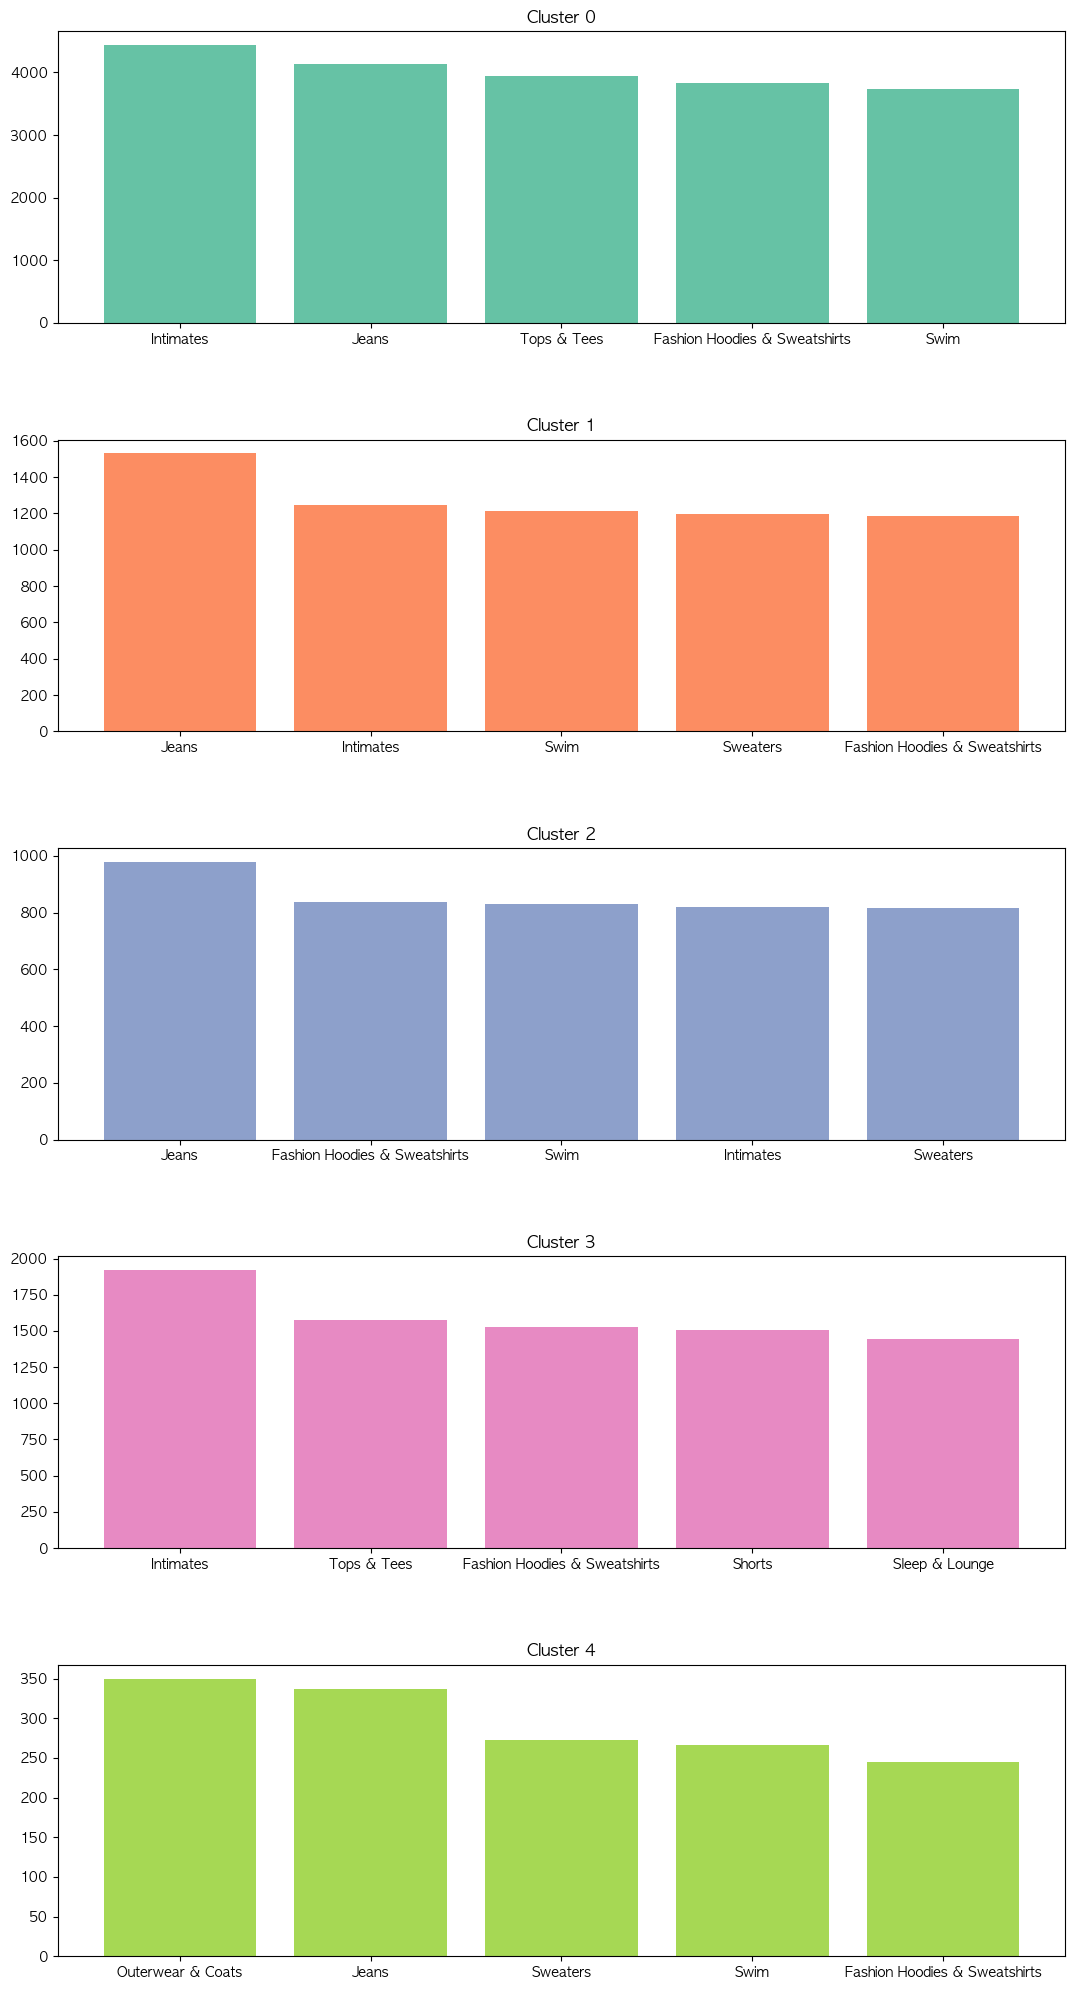

In [34]:
clusters = most_purchased_categories['cluster_CLV2'].value_counts().index.to_list()

cluster_text = ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4']

fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_categories[most_purchased_categories['cluster_CLV2'] == clusters[i]]
    plt.bar(data['product_category'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()


In [35]:
cluster_brand_counts = scaled_rfm_CLV_eda.groupby(['cluster_CLV2', 'product_brand']).size().reset_index(name='count')
cluster_brand_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_brands = cluster_brand_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_brands

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_14810/912663826.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_brands = cluster_brand_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


,cluster_CLV2,product_brand,count
0,0,Allegra K,2114
1,0,Calvin Klein,1052
2,0,Carhartt,882
3,0,Hanes,612
4,0,Volcom,610
5,1,Allegra K,555
6,1,Calvin Klein,362
7,1,Carhartt,264
8,1,Tommy Hilfiger,196
9,1,Volcom,191


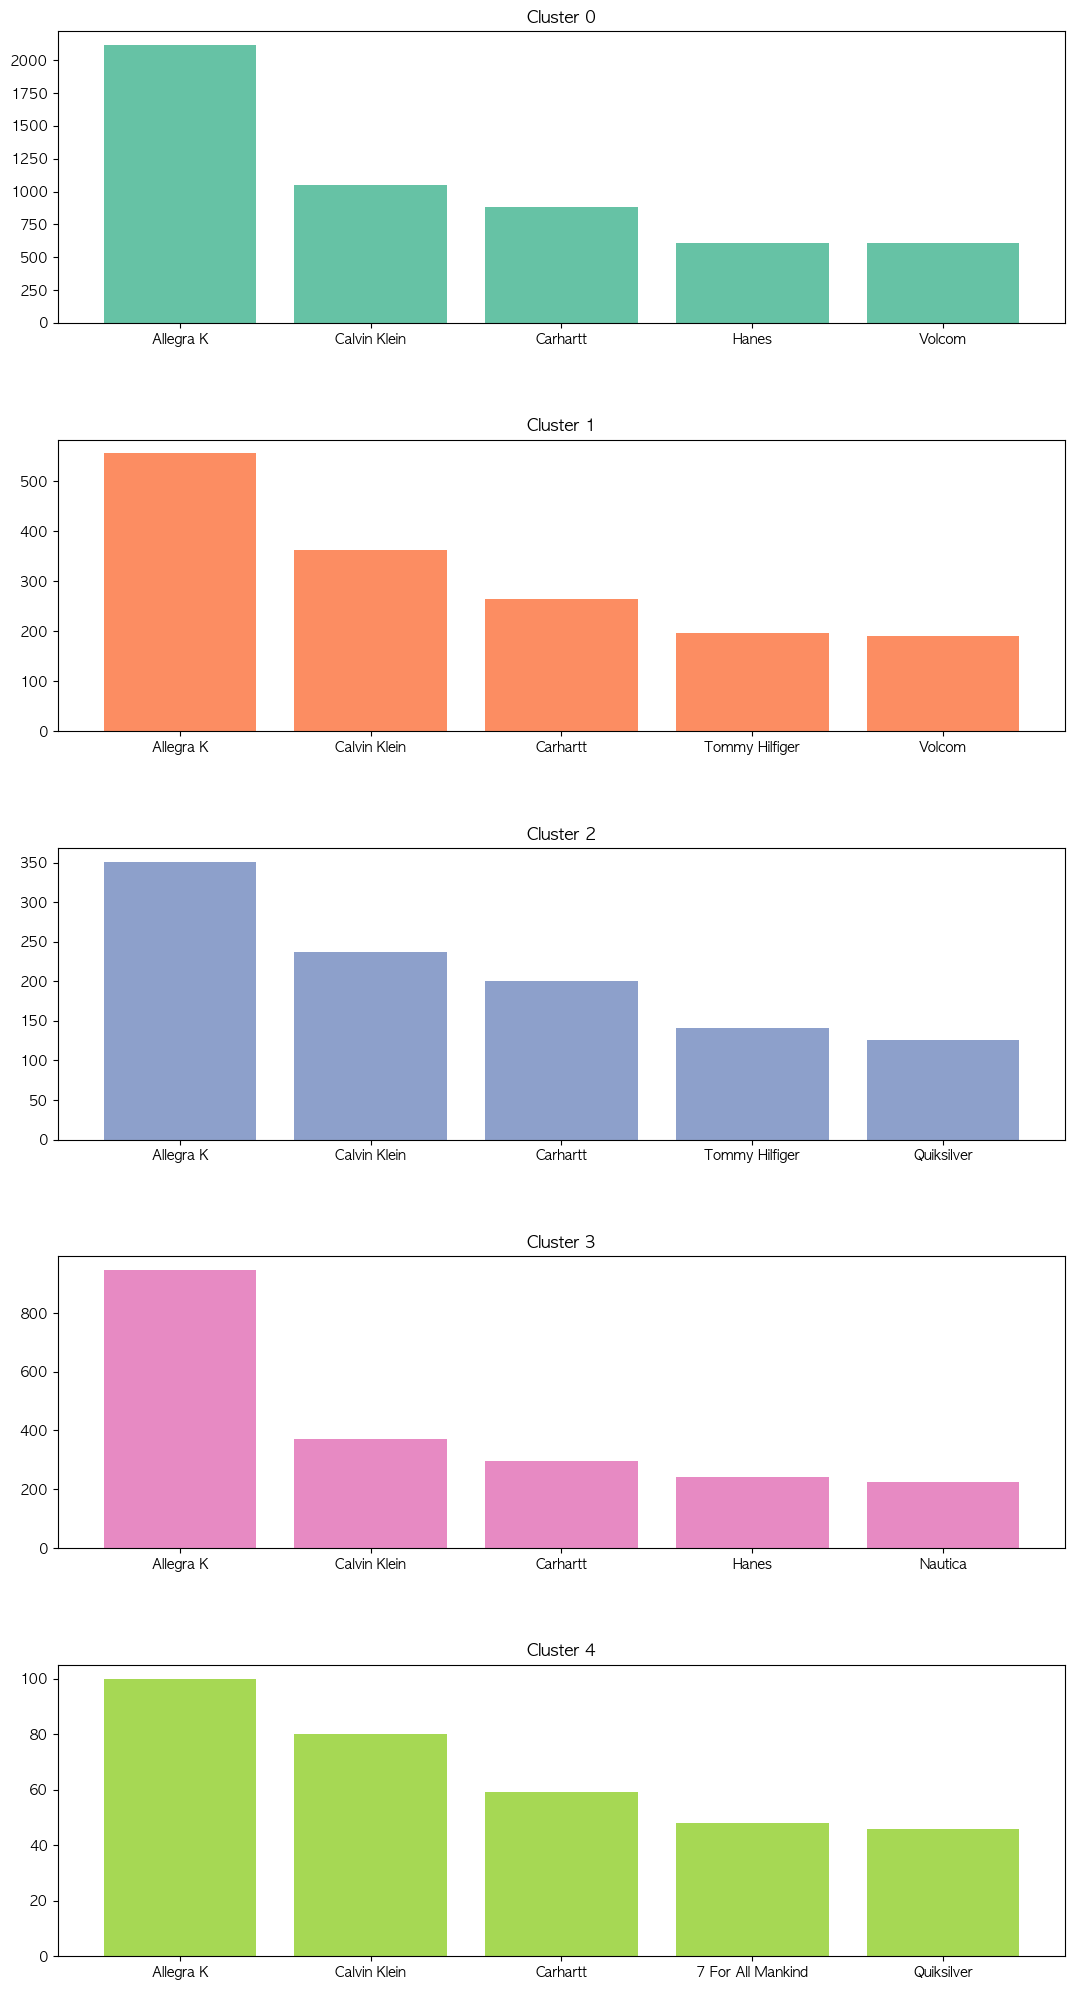

In [36]:
fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_brands[most_purchased_brands['cluster_CLV2'] == clusters[i]]
    plt.bar(data['product_brand'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()

In [37]:
cluster_product_counts = scaled_rfm_CLV_eda.groupby(['cluster_CLV2', 'product_name']).size().reset_index(name='count')
cluster_product_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_product = cluster_product_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_product

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_14810/1127217001.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_product = cluster_product_counts.groupby('cluster_CLV2').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


,cluster_CLV2,product_name,count
0,0,Wrangler Men's Premium Performance Cowboy Cut ...,22
1,0,Curlycue Big Lense Sunglasses,16
2,0,7 For All Mankind Men's Standard Classic Strai...,15
3,0,Puma Men's Socks,15
4,0,Thorlo Men's Wool/Silk Lt Hiker Crew Sock,14
5,1,HUGO BOSS Men's Long Pant,8
6,1,State O Maine Big and Tall Plaid Microfleece L...,8
7,1,DC Men's Chino Pant,7
8,1,Thorlo Unisex Experia Running Sock,7
9,1,Wrangler Men's Premium Performance Cowboy Cut ...,7


In [38]:
scaled_rfm_CLV_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117039 entries, 0 to 117038
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   recency-1           117039 non-null  float64            
 1   frequency           117039 non-null  float64            
 2   monetary            117039 non-null  float64            
 3   user_id             117039 non-null  Int32              
 4   G2                  117039 non-null  float64            
 5   K2                  117039 non-null  float64            
 6   S2                  117039 non-null  float64            
 7   M2                  117039 non-null  float64            
 8   J2                  117039 non-null  float64            
 9   CLV2                117039 non-null  float64            
 10  cluster_CLV2        117039 non-null  int32              
 11  order_item_id       117039 non-null  Int32              
 12  order_id        

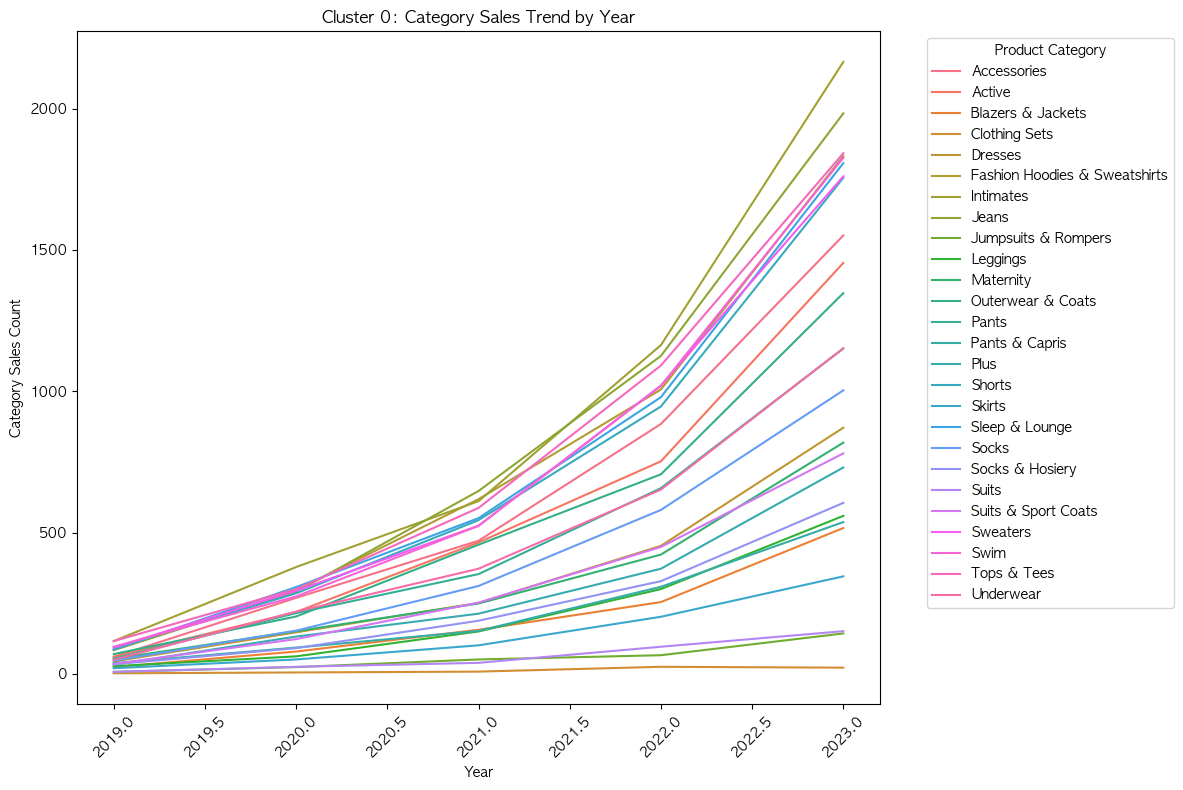

In [39]:
# 'created_at' 열에서 연도 정보만 추출하여 'order_year' 열 생성
scaled_rfm_CLV_eda['order_year'] = scaled_rfm_CLV_eda['created_at'].dt.year

# 연도별 클러스터별 카테고리 판매 수 집계
yearly_cluster_category_counts = scaled_rfm_CLV_eda.groupby(['order_year', 'cluster_CLV2', 'product_category']).size().reset_index(name='count')

# 클러스터 0번의 연도별 카테고리 판매 수 추이 추출
cluster_0_yearly_category_counts = yearly_cluster_category_counts[(yearly_cluster_category_counts['cluster_CLV2'] == 0)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_0_yearly_category_counts, x='order_year', y='count', hue='product_category')
plt.title('Cluster 0: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Count')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

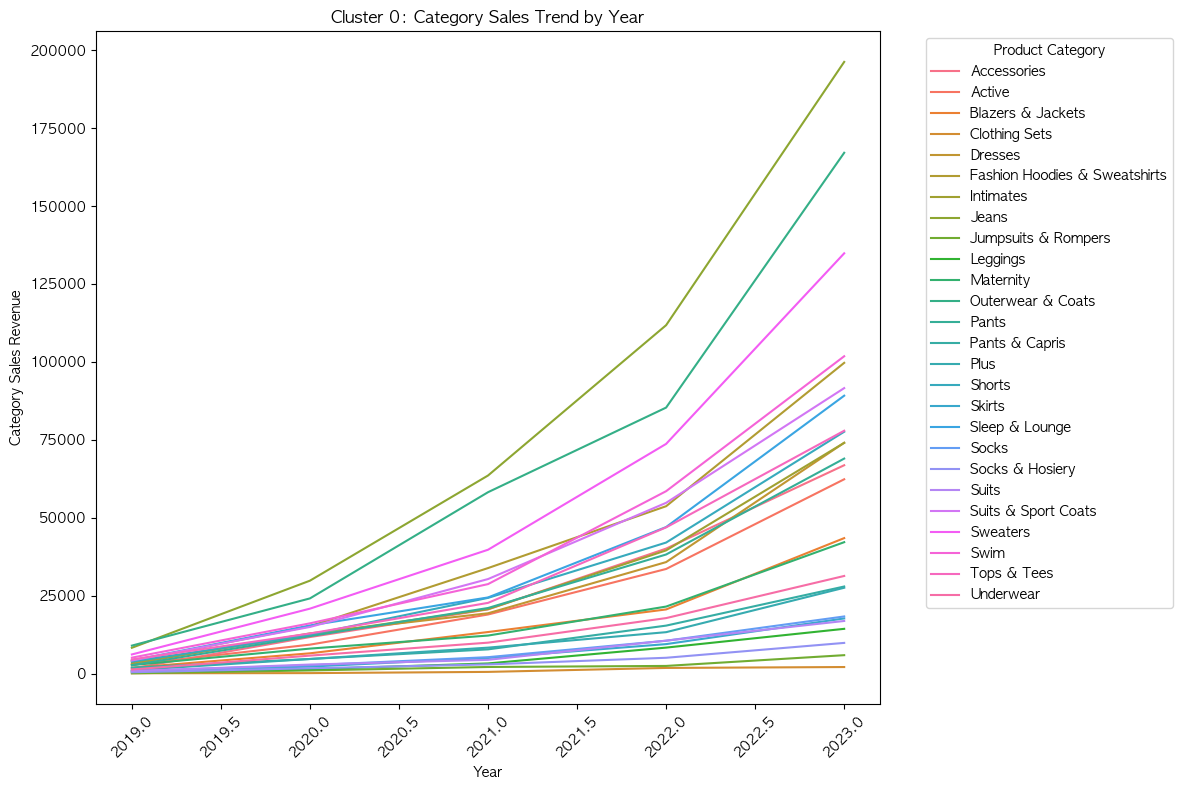

In [40]:
# 'created_at' 열에서 연도 정보만 추출하여 'order_year' 열 생성
scaled_rfm_CLV_eda['order_year'] = scaled_rfm_CLV_eda['created_at'].dt.year

# 연도별 클러스터별 카테고리 판매 수 집계
yearly_cluster_category_revenue = scaled_rfm_CLV_eda.groupby(['order_year', 'cluster_CLV2', 'product_category'])['sale_price'].sum().reset_index(name='sum')

# 클러스터 0번의 연도별 카테고리 판매 수 추이 추출
cluster_0_yearly_category_revenue = yearly_cluster_category_revenue[(yearly_cluster_category_revenue['cluster_CLV2'] == 0)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_0_yearly_category_revenue, x='order_year', y='sum', hue='product_category')
plt.title('Cluster 0: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Revenue')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

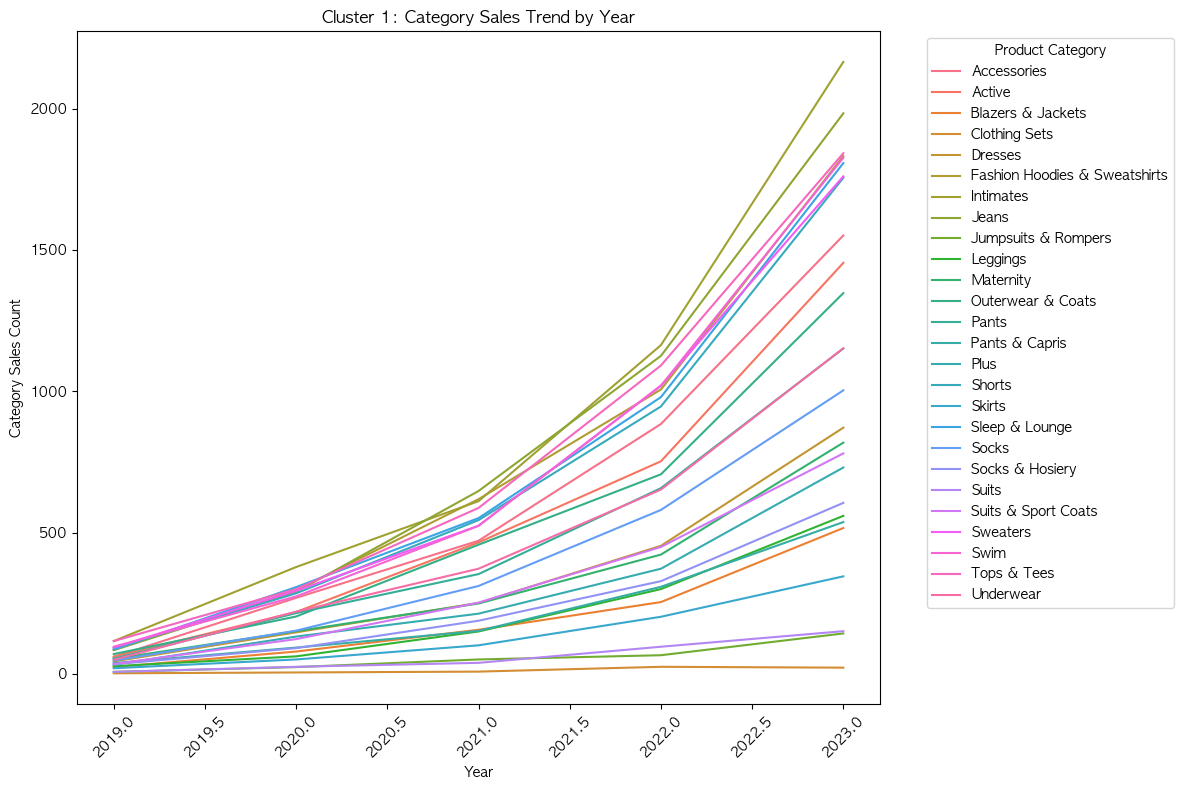

In [41]:
# 'created_at' 열에서 연도 정보만 추출하여 'order_year' 열 생성
# scaled_rfm_CLV_eda['order_year'] = scaled_rfm_CLV_eda['created_at'].dt.year

# 연도별 클러스터별 카테고리 판매 수 집계
yearly_cluster_category_counts = scaled_rfm_CLV_eda.groupby(['order_year', 'cluster_CLV2', 'product_category']).size().reset_index(name='count')

# 클러스터 0번의 연도별 카테고리 판매 수 추이 추출
cluster_1_yearly_category_counts = yearly_cluster_category_counts[(yearly_cluster_category_counts['cluster_CLV2'] == 1)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_0_yearly_category_counts, x='order_year', y='count', hue='product_category')
plt.title('Cluster 1: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Count')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

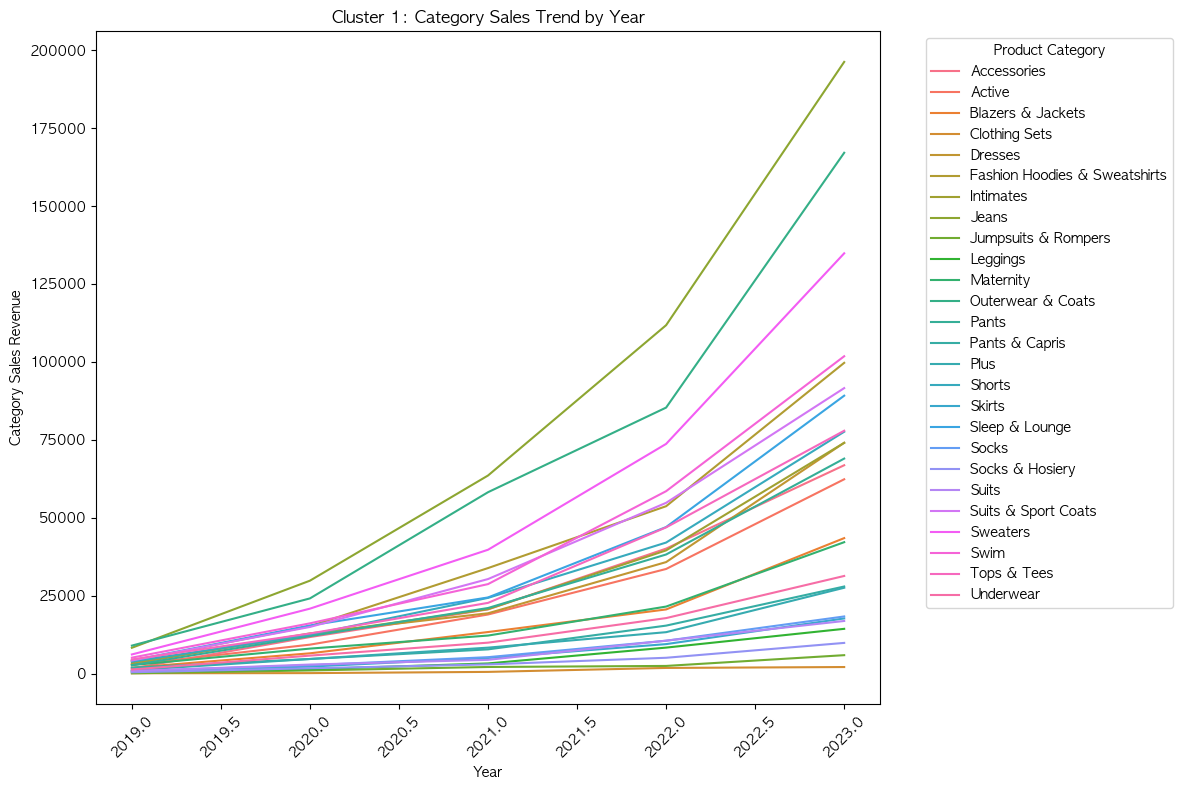

In [42]:
# 'created_at' 열에서 연도 정보만 추출하여 'order_year' 열 생성
# scaled_rfm_CLV_eda['order_year'] = scaled_rfm_CLV_eda['created_at'].dt.year

# 연도별 클러스터별 카테고리 판매 수 집계
# yearly_cluster_category_revenue = scaled_rfm_CLV_eda.groupby(['order_year', 'cluster_CLV2', 'product_category'])['sale_price'].sum().reset_index(name='sum')

# 클러스터 0번의 연도별 카테고리 판매 수 추이 추출
cluster_1_yearly_category_revenue = yearly_cluster_category_revenue[(yearly_cluster_category_revenue['cluster_CLV2'] == 1)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_0_yearly_category_revenue, x='order_year', y='sum', hue='product_category')
plt.title('Cluster 1: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Revenue')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

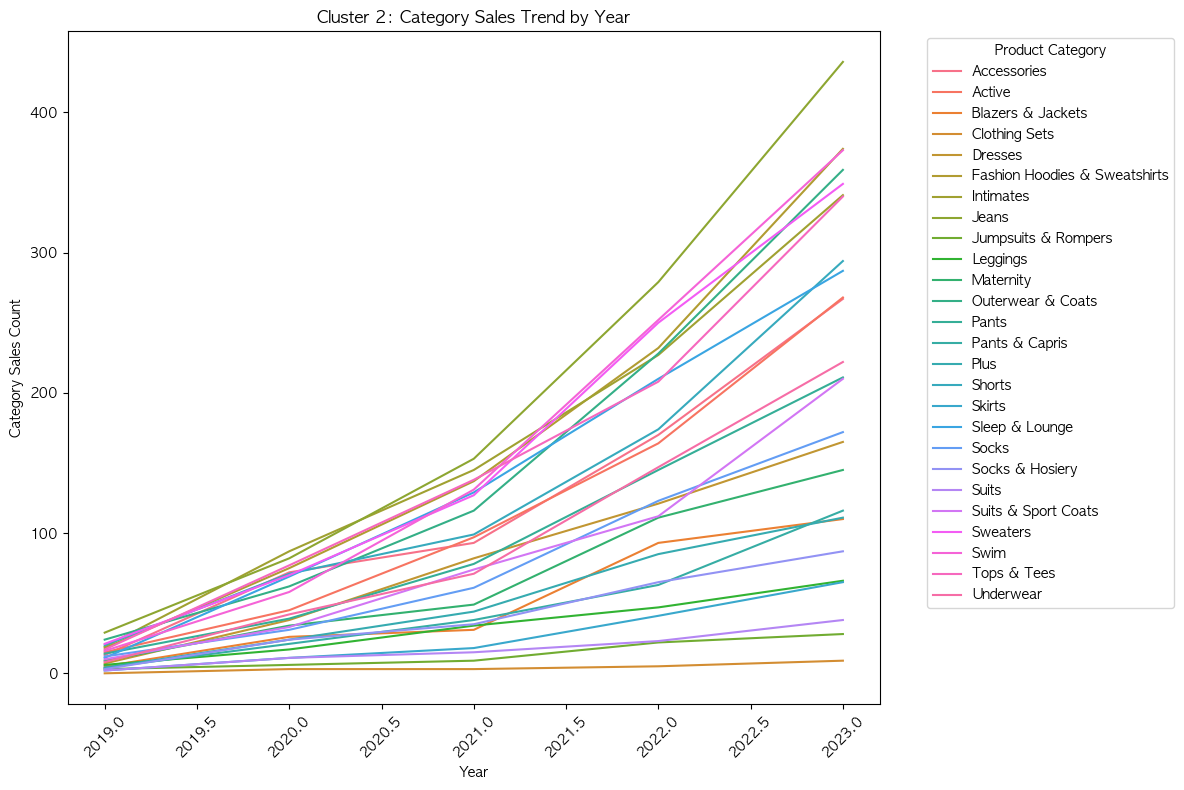

In [43]:
cluster_2_yearly_category_counts = yearly_cluster_category_counts[(yearly_cluster_category_counts['cluster_CLV2'] == 2)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_2_yearly_category_counts, x='order_year', y='count', hue='product_category')
plt.title('Cluster 2: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Count')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

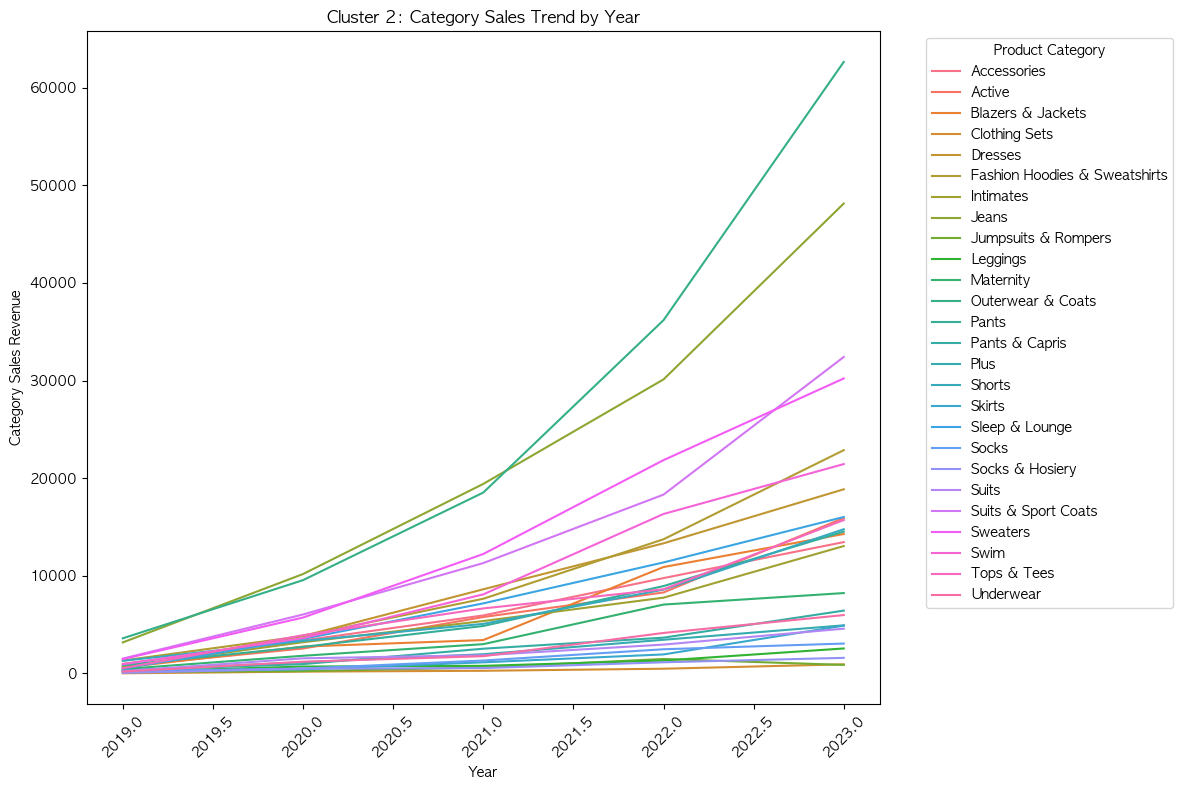

In [44]:
cluster_2_yearly_category_revenue = yearly_cluster_category_revenue[(yearly_cluster_category_revenue['cluster_CLV2'] == 2)]

# 카테고리 판매 수를 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_2_yearly_category_revenue, x='order_year', y='sum', hue='product_category')
plt.title('Cluster 2: Category Sales Trend by Year')
plt.xlabel('Year')
plt.ylabel('Category Sales Revenue')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [45]:
specific_category = 'Jeans'  # 확인하고자 하는 특정 카테고리
filtered_data = scaled_rfm_CLV_eda[scaled_rfm_CLV_eda['product_category'] == specific_category]

# 특정 카테고리에 대한 클러스터 집단의 분포 확인
cluster_distribution = filtered_data['cluster_CLV2'].value_counts()

# 결과 출력
print("Category:", specific_category)
print("Cluster Distribution:")
print(cluster_distribution)

Category: Jeans
Cluster Distribution:
cluster_CLV2
0    4129
1    1530
3    1231
2     979
4     337
Name: count, dtype: int64


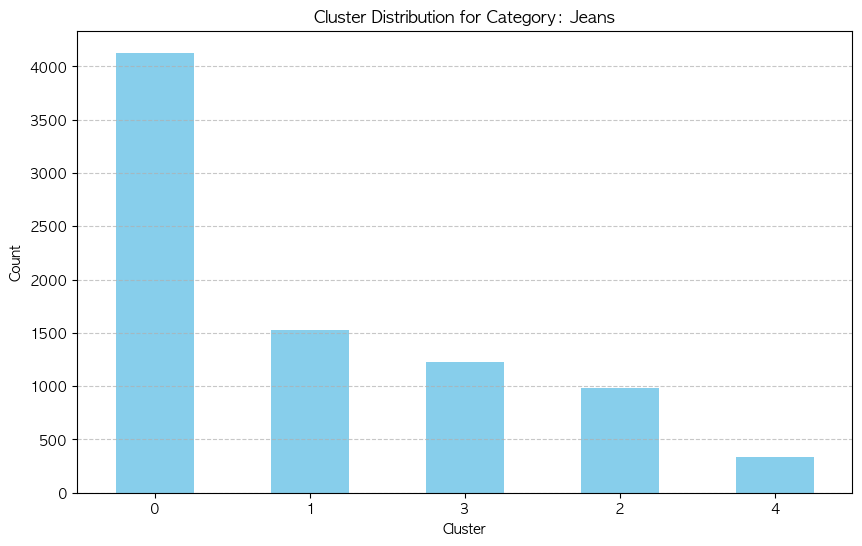

In [46]:
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind='bar', color='skyblue')
plt.title('Cluster Distribution for Category: ' + specific_category)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 2500x1000 with 0 Axes>

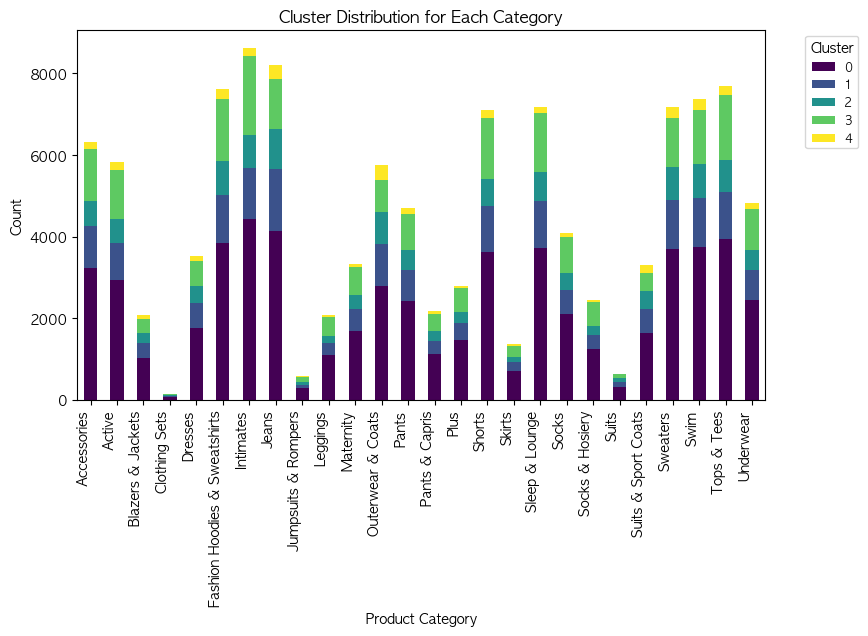

In [47]:
# 특정 카테고리에 대한 클러스터 집단의 분포 확인
cluster_distribution = scaled_rfm_CLV_eda.groupby('product_category')['cluster_CLV2'].value_counts().unstack().fillna(0)

# 누적 막대 그래프로 시각화
plt.figure(figsize=(25, 10))
cluster_distribution.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Cluster Distribution for Each Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# 여백 조절
plt.subplots_adjust(right=1.2)  # 여기서 right 값을 조절하여 그래프와 범례 사이의 여백을 조정
plt.show()

In [52]:
scaled_rfm_CLV_eda.sale_price.max()

999.0

In [54]:
max_sale_price = scaled_rfm_CLV_eda['sale_price'].max()  # 가장 비싼 금액
max_sale_price_row = scaled_rfm_CLV_eda[scaled_rfm_CLV_eda['sale_price'] == max_sale_price]
max_sale_price_row


,recency-1,frequency,monetary,user_id,G2,K2,S2,M2,J2,CLV2,cluster_CLV2,order_item_id,order_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,cost,product_category,product_name,product_brand,product_department,profit,order_year
4991,12.699664,7.333333,8.821029,4283,8.821029,64.687547,5.093642,17.575284,0.694588,96.872090,4,7801,5416,24447,21078,Shipped,2022-01-12 23:51:07+00:00,2022-01-10 03:42:00+00:00,NaT,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2022
23135,16.748322,1.000000,16.061148,19650,16.061148,16.061148,0.958971,0.000000,0.958971,34.040238,3,35807,24643,24447,96616,Processing,2023-01-28 15:06:39+00:00,NaT,NaT,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2023
24015,18.214765,1.000000,15.154362,20434,15.154362,15.154362,0.831982,0.000000,0.831982,31.972689,3,37188,25610,24447,100325,Complete,2023-06-15 11:58:18+00:00,2023-06-16 11:03:00+00:00,2023-06-20 14:13:00+00:00,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2023
25376,19.521812,1.000000,19.589113,21671,19.589113,19.589113,1.003447,0.000000,1.003447,41.185120,1,39329,27087,24447,106092,Complete,2023-10-16 06:50:15+00:00,2023-10-13 13:03:00+00:00,2023-10-15 07:26:00+00:00,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2023
26553,18.236018,7.333333,9.954512,22656,9.954512,72.999751,4.003053,19.833669,0.545871,107.336856,4,41201,28344,23546,111165,Complete,2023-06-17 15:30:18+00:00,2023-06-18 09:20:00+00:00,2023-06-19 07:29:00+00:00,NaT,999.0,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men,516.483001,2023
33192,19.638702,1.000000,20.000000,28392,20.000000,20.000000,1.018397,0.000000,1.018397,42.036794,1,51581,35450,23546,139190,Processing,2023-10-24 18:42:24+00:00,NaT,NaT,NaT,999.0,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men,516.483001,2023
40422,17.067114,1.000000,16.812081,34691,16.812081,16.812081,0.985057,0.000000,0.985057,35.594275,3,62986,43364,23546,169937,Shipped,2023-02-26 00:38:43+00:00,2023-02-25 06:53:00+00:00,NaT,NaT,999.0,482.516999,Shorts,Alpha Industries Rip Stop Short,Alpha Industries,Men,516.483001,2023
68735,19.819351,7.333333,8.225951,58623,8.225951,60.323639,3.043674,16.389632,0.415046,88.397943,4,106577,73418,24447,287560,Shipped,2023-11-12 02:41:02+00:00,2023-11-14 20:44:00+00:00,NaT,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2023
92803,13.337248,7.333333,9.203579,78981,9.203579,67.492916,5.060483,18.337489,0.690066,100.784533,4,143759,98984,24447,388091,Shipped,2022-03-13 10:29:49+00:00,2022-03-14 01:27:00+00:00,NaT,NaT,999.0,404.595001,Outerwear & Coats,Darla,Alpha Industries,Men,594.404999,2022


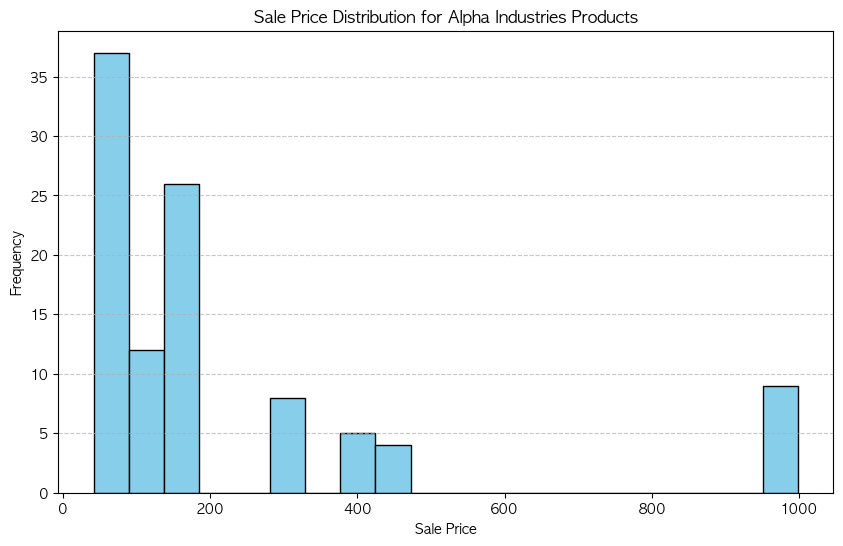

In [55]:
import matplotlib.pyplot as plt

# 조건에 맞는 데이터 필터링
alpha_industries_products = scaled_rfm_CLV_eda[scaled_rfm_CLV_eda['product_brand'] == 'Alpha Industries']

# sale_price 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(alpha_industries_products['sale_price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sale Price Distribution for Alpha Industries Products')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [56]:
products

,product_id,cost,category,product_name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.51875,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.33835,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.87956,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.64877,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.50793,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1
...,...,...,...,...,...,...,...,...,...
29115,5676,12.42338,Pants & Capris,WHAT GOES AROUND COMES AROUND Women's Colette ...,What Goes Around Comes Around,24.17,Women,3A01FC0853EBEBA94FDE4D1CC6FB842A,10
29116,6538,13.67500,Shorts,WHAT GOES AROUND COMES AROUND Women's Mimi Shorts,What Goes Around Comes Around,25.00,Women,741A0099C9AC04C7BFC822CAF7C7459F,10
29117,6712,12.40000,Shorts,WHAT GOES AROUND COMES AROUND Women's Fifi Short,What Goes Around Comes Around,25.00,Women,5726DAF2C9EE0F955ECA58291C26D2F3,10
29118,6821,13.47500,Shorts,WHAT GOES AROUND COMES AROUND Women's Ferguson...,What Goes Around Comes Around,25.00,Women,BA0A4D6ECEA3E9E126DD3B6D77291C97,10


In [59]:
products[products['brand']=='Alpha Industries'].value_counts()

product_id  cost        category           product_name                                                                                             brand             retail_price  department  sku                               distribution_center_id
19361       32.121599   Sweaters           Tamrac Pull Over                                                                                         Alpha Industries  67.199997     Men         C407746DC64EA0B220CC3148BDEDF4B2  5                         1
23992       71.280000   Outerwear & Coats  Injector (183112)                                                                                        Alpha Industries  176.000000    Men         902447C6CE9D4F39E12A463B4D4FF759  5                         1
24441       38.395199   Outerwear & Coats  Alpha Industries M-65 Water-Repellent Field Jacket. Made In The USA. Available in All Sizes and Colors.  Alpha Industries  79.989998     Men         A43FDD75A502C38F7606BA323FDB0DC6  5                

In [62]:
users= pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet")

In [66]:
users.isnull().sum()

user_id                  0
first_name               0
last_name                0
email                    0
age                      0
gender                   0
state                    0
street_address           0
postal_code              0
city                   958
country                  0
user_latitude            0
user_longitude           0
user_traffic_source      0
user_created_at          0
dtype: int64